In [1]:
from sklearn import datasets
from sklearn.svm import SVC
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from utils import visualize_optimizer

## Zadanie 1

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, random_state=1, n_features=2, centers = 2, cluster_std = 2.4)

# Standaryzacja
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Model z C = 0.01:

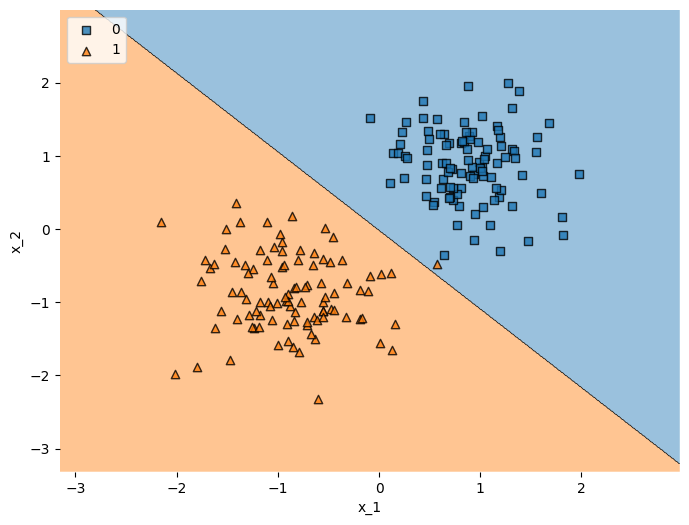

In [3]:
svm = SVC(kernel='linear', C=0.01, random_state=0)
svm.fit(X_train_std, y_train)

plt.figure(figsize=(8, 6))

X_all = np.vstack((X_train_std, X_test_std))
y_all = np.hstack((y_train, y_test))
plot_decision_regions(X=X_all, y=y_all, clf=svm)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend(loc='upper left')
plt.show()

### Model z C = 0.1:

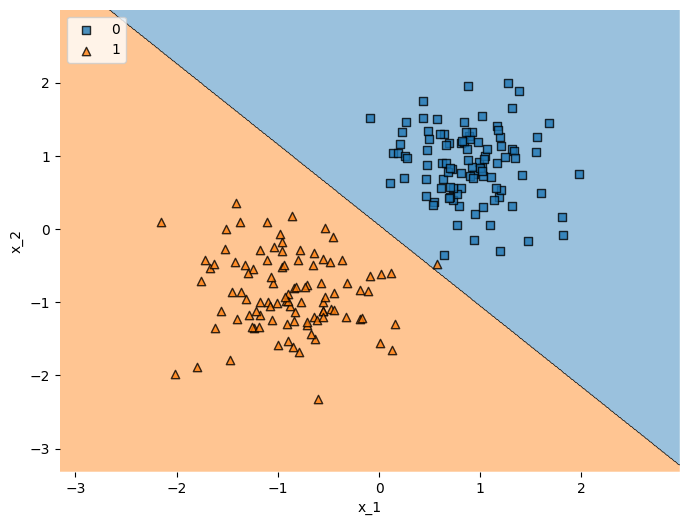

In [4]:
svm = SVC(kernel='linear', C=0.1, random_state=0)
svm.fit(X_train_std, y_train)

plt.figure(figsize=(8, 6))

X_all = np.vstack((X_train_std, X_test_std))
y_all = np.hstack((y_train, y_test))
plot_decision_regions(X=X_all, y=y_all, clf=svm)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend(loc='upper left')
plt.show()

### Model z C = 1:

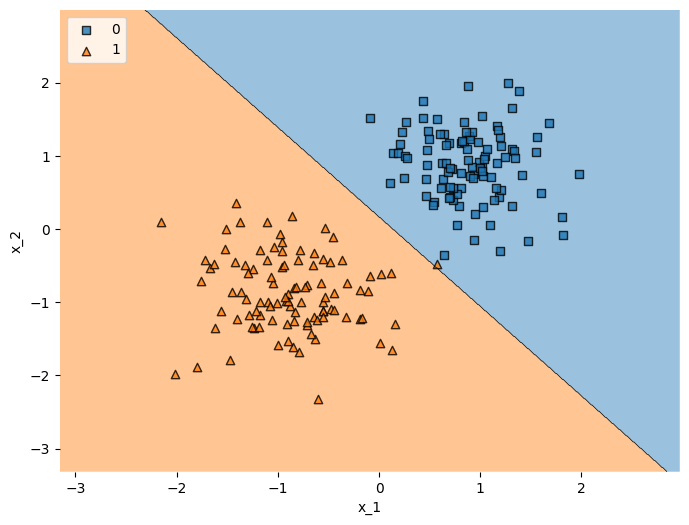

In [5]:
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)

plt.figure(figsize=(8, 6))

X_all = np.vstack((X_train_std, X_test_std))
y_all = np.hstack((y_train, y_test))
plot_decision_regions(X=X_all, y=y_all, clf=svm)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend(loc='upper left')
plt.show()

### Model z C = 10:

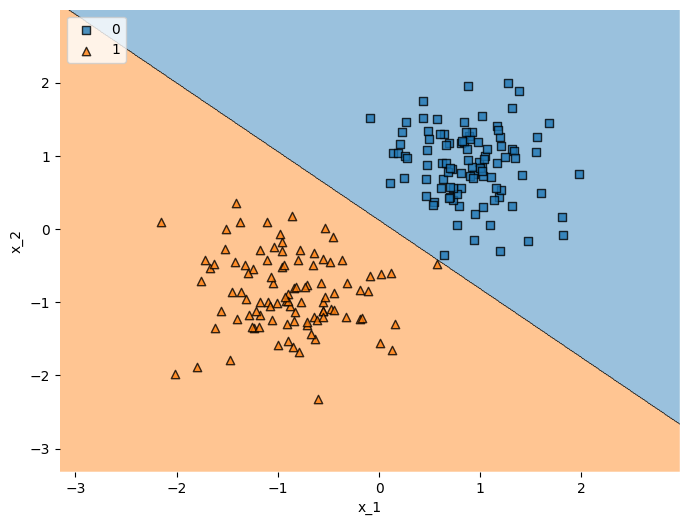

In [6]:
svm = SVC(kernel='linear', C=10.0, random_state=0)
svm.fit(X_train_std, y_train)

plt.figure(figsize=(8, 6))

X_all = np.vstack((X_train_std, X_test_std))
y_all = np.hstack((y_train, y_test))
plot_decision_regions(X=X_all, y=y_all, clf=svm)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend(loc='upper left')
plt.show()

### Komentarz:

Widać jak wraz ze wzrastającym C granica decyzji przemieszczała się tak aby sklasyfikować wszystkie punkty możliwie poprawnie.
Przy małym C dużo ważniejsze (z punktu widzenia minimalizowanej funkcji kosztu) było to aby zachować możliwie równe marginesy
między kategoriami punktów. Przy dużym C kara za niepoprawną klasyfikację punktu zaczyna mieć przeważające znaczenie - granica decyzji
tworzy nierówne marginesy ale za to poprawnie klasyfikuje wszystkie punkty.

## Zadanie 2

In [7]:
def plot_svm_model(gamma):
    svm = SVC(kernel='rbf', C=1.0, gamma=gamma, random_state=0)
    svm.fit(X_train_std, y_train)

    plt.figure(figsize=(8, 6))
    plot_decision_regions(X=X_all , y=y_all , clf=svm)
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.legend(loc='upper left')
    plt.show()

### Model dla $\gamma$ = 10:

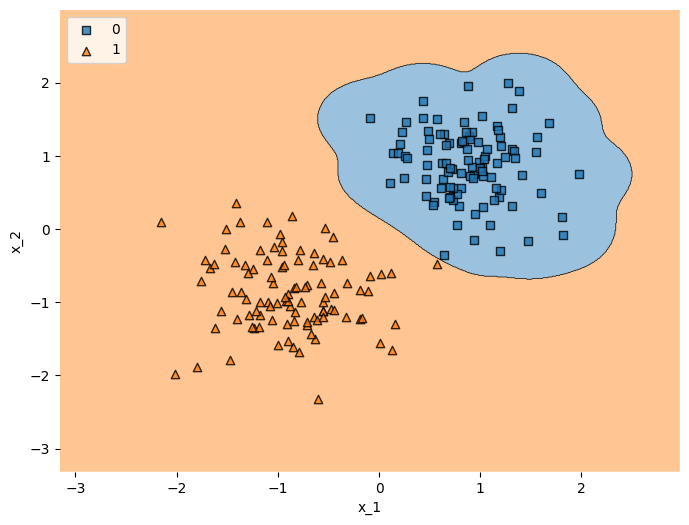

In [8]:
plot_svm_model(10.0)

### Model dla $\gamma$ = 20:

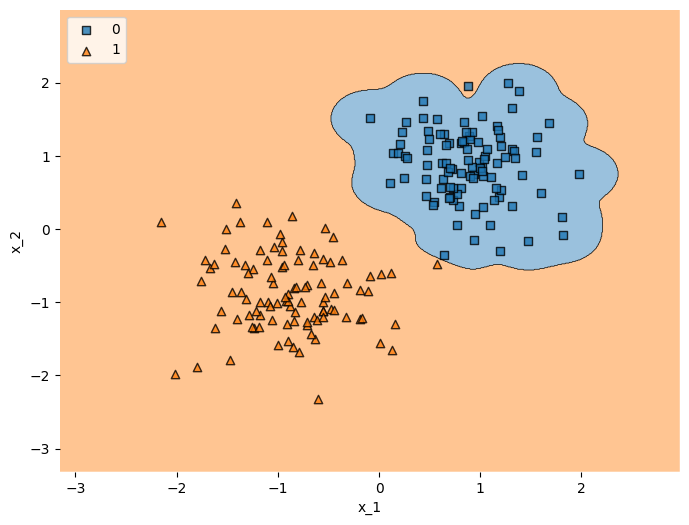

In [9]:
plot_svm_model(20.0)

### Model dla $\gamma$ = 30:

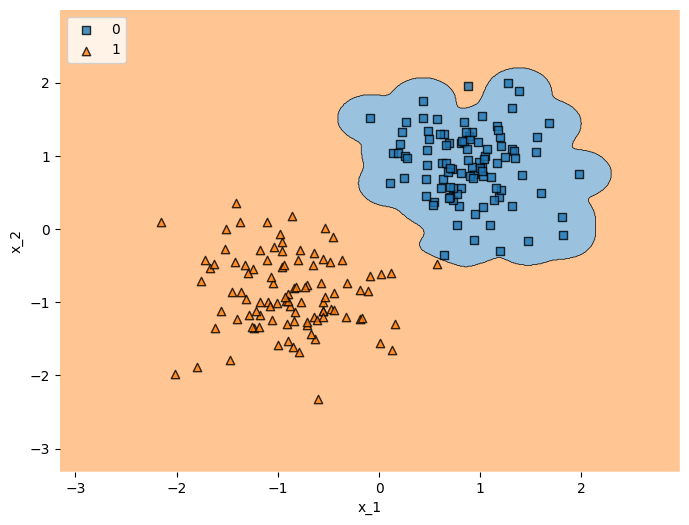

In [10]:
plot_svm_model(30.0)

### Model dla $\gamma$ = 40:

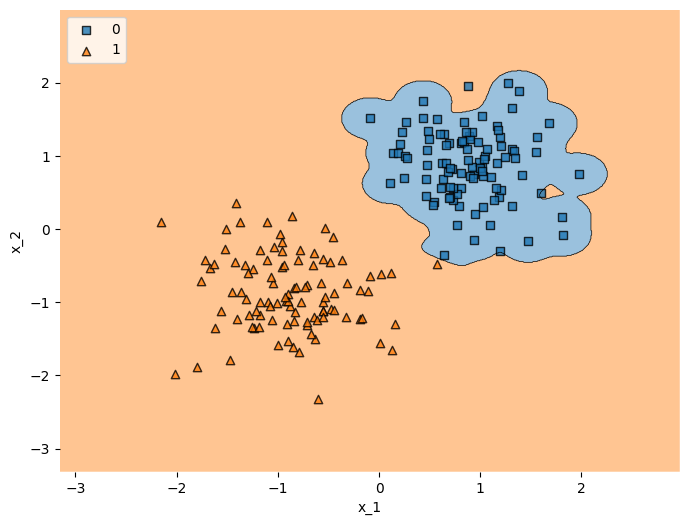

In [11]:
plot_svm_model(40.0)

### Model dla $\gamma$ = 50:

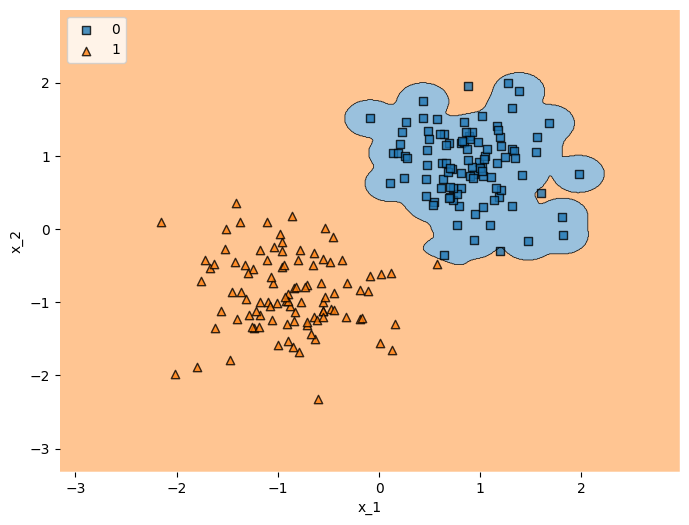

In [12]:
plot_svm_model(50.0)

### Komentarz:

Widać, że wraz ze wzrostem $\gamma$ dopasowanie krawędzi decyzji do danych rośnie. W przypadku dużych wartości $\gamma$ do tego stopnia, że opłacalne
wydaje się wykluczenie niektórych punktów aby otrzymać dokładniej opasane klastry.

## Zadanie 3

In [13]:
class Optimizer:
    """Base class for each optimizer"""
    
    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params
    
    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

In [14]:
class Momentum(Optimizer):
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        self.deltas = []
        
        for param in self.params:
            self.deltas.append(torch.zeros_like(param))
              
    @torch.no_grad()
    def step(self):
        for delta, param in zip(self.deltas, self.params):
            delta *= self.gamma
            delta += self.learning_rate * param.grad
            param -= delta

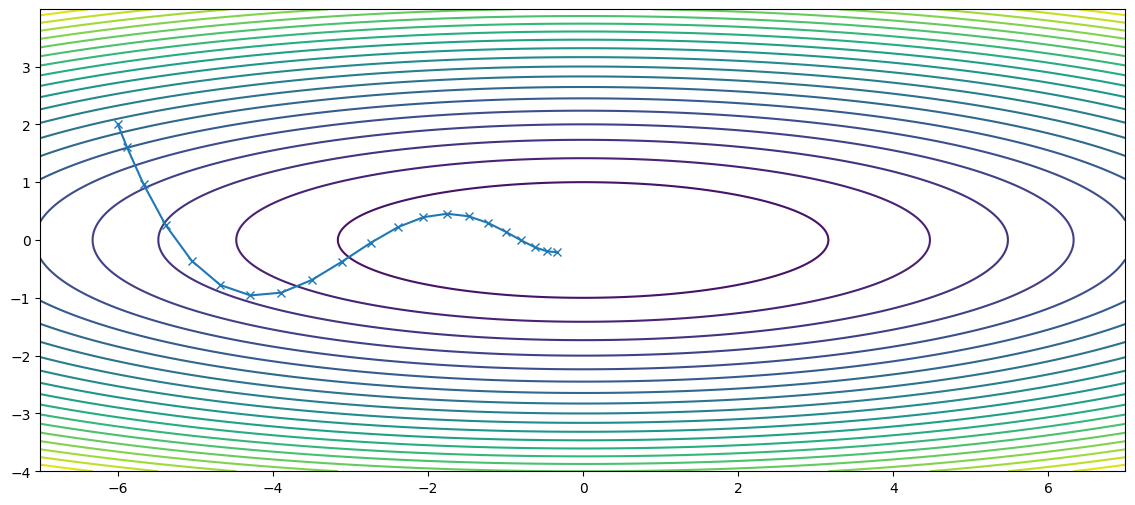

In [15]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

## Zadanie 4

In [16]:
class Adagrad(Optimizer):
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        self.g = []
        
        for param in self.params:
            self.g.append(torch.zeros_like(param))
    
    @torch.no_grad()
    def step(self):        
        for g, param in zip(self.g, self.params):
            g += torch.pow(param.grad, 2)
            param -= (self.learning_rate / torch.sqrt(g + self.epsilon)) * param.grad

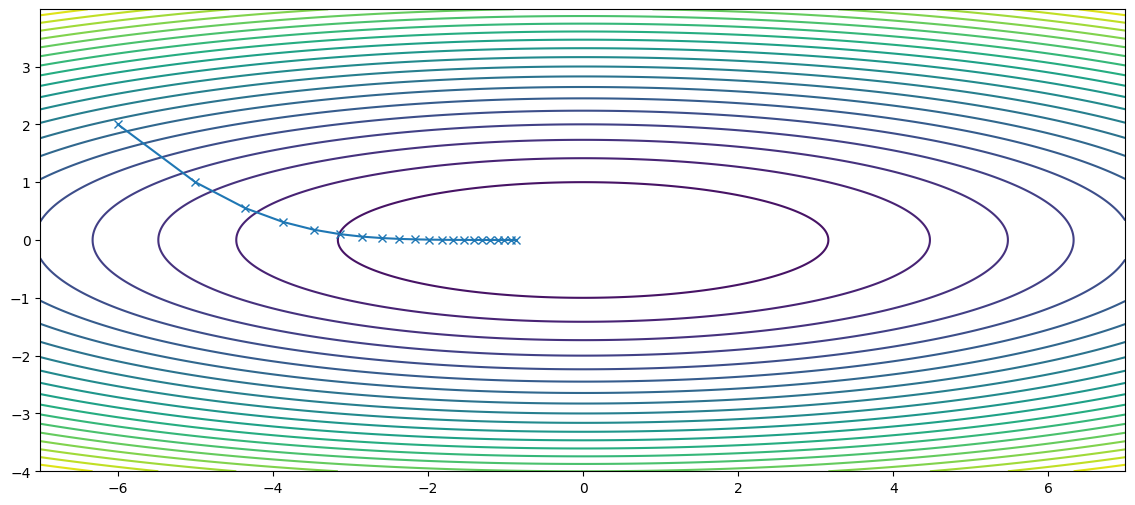

In [17]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

## Zadanie 5

In [18]:
class RMSProp(Optimizer):
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.h = []
        
        for param in self.params:
            self.h.append(torch.zeros_like(param))
        
    @torch.no_grad()
    def step(self):
        for h, param in zip(self.h, self.params):
            h *= self.gamma
            h += (1 - self.gamma) * torch.pow(param.grad, 2)
            
            param -= (self.learning_rate / torch.sqrt(h + self.epsilon)) * param.grad

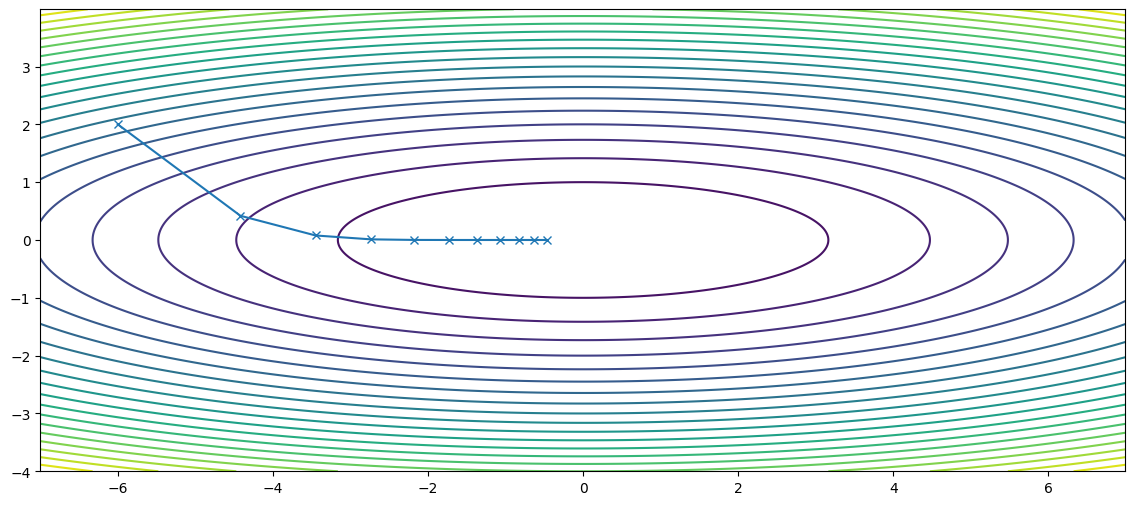

In [19]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

## Zadanie 6

In [20]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon

        self.d = []
        self.h = []
        
        for param in self.params:
            self.d.append(torch.zeros_like(param))
            self.h.append(torch.zeros_like(param))
        
    @torch.no_grad()
    def step(self):
        for d, h, param in zip(self.d, self.h, self.params):
            h *= self.gamma
            h += (1 - self.gamma) * torch.pow(param.grad, 2)
            
            delta = (torch.sqrt(d + self.epsilon) / torch.sqrt(h + self.epsilon)) * param.grad
            
            param -= delta
            
            d *= self.gamma
            d += (1 - self.gamma) * torch.pow(delta, 2)

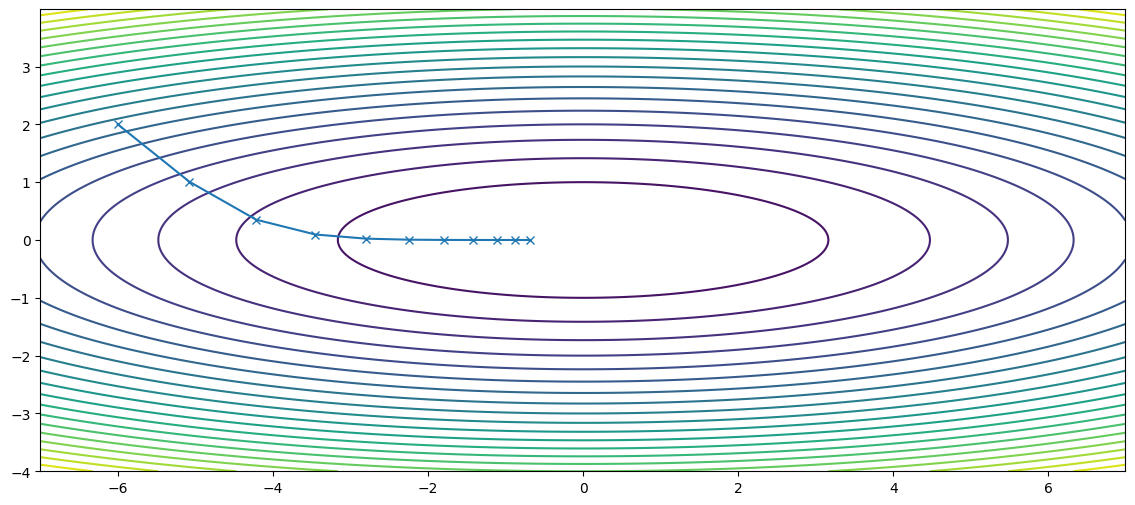

In [21]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1)

## Zadanie 7

In [22]:
class Adam(Optimizer):
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.m = []
        self.v = []
        self.t = 0
        
        for param in self.params:
            self.m.append(torch.zeros_like(param))
            self.v.append(torch.zeros_like(param))
        
    @torch.no_grad()
    def step(self,):
        for m, v, param in zip(self.m, self.v, self.params):
            m *= self.beta1
            m += (1 - self.beta1) * param.grad
            
            v *= self.beta2
            v += (1 - self.beta2) * torch.pow(param.grad, 2)
            
            m_hat = m / (1 - self.beta1 ** (self.t + 1))
            v_hat = v / (1 - self.beta2 ** (self.t + 1))
            
            param -= self.learning_rate * (m_hat / (torch.sqrt(v_hat) + self.epsilon))
            
        self.t += 1

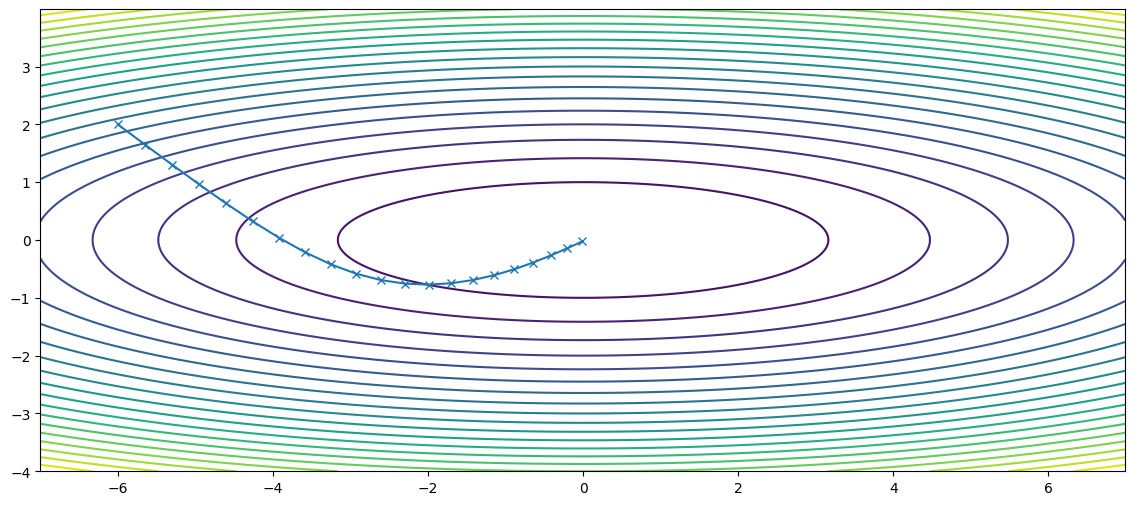

In [23]:
visualize_optimizer(Adam, n_steps=20, learning_rate=0.35, beta1=0.9, beta2=0.999, epsilon=1e-8)